# Convolution Neural Network (CNN) & Artificial Neural Network (ANN)
Name: Andrea Filiberto Lucas<br>
ID No: 0279704L<br>
Course: ARI2201 - Artificial Intelligence (AI)<br>

## Introduction

This notebook focuses on the in-depth analysis and classification of respiratory sound data. Respiratory sounds, such as wheezes and crackles, serve as significant indicators for various respiratory conditions. Analysing these sounds can help with the early detection and diagnosis of diseases such as COPD, asthma, and pneumonia. This approach uses machine learning (ML) techniques to improve diagnostic accuracy and efficiency in clinical settings.

### Objectives

- `Data Loading & Preprocessing`: Load the respiratory sound files and corresponding diagnosis data, preprocess the data, and extract relevant features.
- `Data Visualization`: Visualize class distributions, audio file durations, and other relevant metrics to understand the dataset better.
- `Model Building and Evaluation`: Build and train a Convolutional Neural Network (CNN) and an Artificial Neural Network (ANN) to classify the respiratory sounds into different disease categories. Evaluate the model using various metrics to ensure its performance.
- `Result Interpretation`: Analyze the results, visualize model performance, and interpret the findings to gain insights into the model's effectiveness.

## Convolutional Neural Network (CNN)
A Convolutional Neural Network (CNN) is a specialized type of Artificial Neural Network (ANN) designed for processing structured grid data, such as images. CNNs are particularly effective for image recognition and classification tasks due to their ability to automatically and adaptively learn spatial hierarchies of features through convolutional layers, pooling layers, and fully connected layers.

## Artificial Neural Network (ANN)
An Artificial Neural Network (ANN) is a broad category of machine learning models inspired by the human brain's neural networks. ANNs consist of interconnected layers of nodes (neurons), including an input layer, one or more hidden layers, and an output layer. These networks can be trained to recognize patterns and make predictions based on input data, and they are used for a wide range of tasks including regression, classification, and time series prediction.
## Importing the necessary libraries & modules.
First, all libraries used in this Jupyter notebook are imported:

- **`os`, `os.path`, `time`**: Directory operations, file status checks, and delays.
- **`tabulate`, `tqdm`**: Text tables and progress bars.
- **`pandas`,`numpy`, `librosa`**: Data manipulation, numerical operations, and audio processing.
- **`matplotlib.pyplot`**: Plotting and visualizations.
- **`sklearn.model_selection`, `timeit`**: Dataset splitting and time measurement.
- **`wave`**: Handling .wav audio files.
- **`sklearn.metrics`, `seaborn`**: Model evaluation and statistical visualization.
- **`itertools.cycle`**: Cycling through colors.
- **`tensorflow.keras`**: Building, regularizing, optimizing, and visualizing neural networks, including specific layers and the Adam optimizer.

In [1]:
# Importing the os module for directory operations
import os

# Importing isfile and join functions from os.path to check file status and create file paths
from os.path import isfile, join

# Import time for delays
import time

# Import tabulate for generating tables in text format
from tabulate import tabulate # type: ignore

# Import tqdm for creating progress bars
from tqdm import tqdm # type: ignore

# Importing pandas for data manipulation and analysis
import pandas as pd # type: ignore

# Importing librosa for audio processing
import librosa # type: ignore

# Importing pyplot from matplotlib for plotting
import matplotlib.pyplot as plt # type: ignore

# Importing numpy for numerical operations
import numpy as np # type: ignore

# Importing train_test_split for splitting datasets
from sklearn.model_selection import train_test_split # type: ignore

# Importing timer to measure time intervals
from timeit import default_timer as timer

# Importing the wave module to handle .wav audio files
import wave

'''
============================== Evaluation ============================== 
'''

# Importing classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve for model evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve # type: ignore
# Importing seaborn for statistical data visualization
import seaborn as sn # type: ignore

# Import cycle from itertools for cycling through colors
from itertools import cycle

'''
============================== TENSORFLOW ============================== 
'''

# Importing Sequential and Model from tensorflow.keras for building neural networks
from tensorflow.keras.models import Sequential, Model # type: ignore

# Importing regularizers and optimizers from tensorflow.keras for regularization and optimization
from tensorflow.keras import regularizers, optimizers # type: ignore

# Importing various neural network layers from tensorflow.keras
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout # type: ignore

# Importing plot_model for model visualization and to_categorical for one-hot encoding
from tensorflow.keras.utils import plot_model, to_categorical # type: ignore

# Import the Adam optimizer from tensorflow.keras
from tensorflow.keras.optimizers import Adam # type: ignore

/Users/afl/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Parsing the Dataset
A `Diagnosis` class is defined with an initializer to store patient information:

- **patient_id**: The ID of the patient.
- **diagnosis**: The diagnosis of the patient.
- **audio_file_path**: The file path to the patient's audio file.


In [2]:
class Diagnosis:
    def __init__(self, patient_id, diagnosis, audio_file_path):
        self.patient_id = patient_id
        self.diagnosis = diagnosis
        self.audio_file_path = audio_file_path

### Paths
Dynamic paths are defined for accessing files:

- **`PATH`**: Directory path to audio and text files.
- **`diagnosis_file`**: Path to the patient diagnosis CSV file.


In [3]:
# Dynamic paths
PATH = '../Respiratory_Sound_Database/audio_and_txt_files/'
diagnosis_file = '../Respiratory_Sound_Database/patient_diagnosis.csv'

### Retrieving Audio Files from a Directory

`get_wav_files(PATH)`:
- Checks if the directory exists, raises an error if not.
- Retrieves and sorts `.wav` files from the directory.
- Raises an error if no `.wav` files are found.
- Returns the list of `.wav` files and the directory path.

In [4]:
# Function to get a list of .wav files in the audio directory
def get_wav_files(PATH):
    if not os.path.isdir(PATH):
        raise ValueError(f"The directory {PATH} does not exist.")
    
    try:
        # Get all files in the directory
        files = [f for f in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, f))]
        # Filter the files to only include .wav files
        wav_files = sorted([f for f in files if f.endswith('.wav')])
    except Exception as e:
        raise RuntimeError(f"Error while accessing files in the directory {PATH}: {e}")
    
    if not wav_files:
        raise FileNotFoundError("No .wav files found in the directory.")
    
    return wav_files, PATH

### Loading and Mapping Diagnosis Data to Audio Files

`load_diagnosis_data(PATH, diagnosis_file)`:
- Checks if the diagnosis file exists, raises an error if not.
- Reads the diagnosis file into a DataFrame, handling possible read errors.
- Retrieves the list of `.wav` files and the audio path.
- Creates a dictionary mapping patient IDs to diagnoses.
- Iterates over `.wav` files, extracting patient IDs and associating diagnoses.
- Creates `Diagnosis` objects for each `.wav` file, appending them to a list.
- Returns the list of `Diagnosis` objects.

In [5]:
def load_diagnosis_data(PATH, diagnosis_file):
    # Check if diagnosis file exists
    if not os.path.isfile(diagnosis_file):
        raise ValueError(f"The file {diagnosis_file} does not exist.")
    
    try:
        # Read diagnosis file into a DataFrame
        diagnosis_df = pd.read_csv(diagnosis_file)
    except pd.errors.EmptyDataError:
        raise ValueError("Diagnosis file is empty.")
    except pd.errors.ParserError:
        raise ValueError("Diagnosis file is not properly formatted.")
    except Exception as e:
        raise RuntimeError(f"Error while reading the diagnosis file {diagnosis_file}: {e}")
    
    if diagnosis_df.empty:
        raise ValueError("Diagnosis file is empty.")
    
    # Get the list of .wav files and the audio path
    wav_files, audio_path = get_wav_files(PATH)
    
    try:
        # Create a dictionary mapping patient IDs to diagnoses
        diagnosis_dict = {row.iloc[0]: row.iloc[1] for _, row in diagnosis_df.iterrows()}
    except KeyError as e:
        raise ValueError(f"Missing expected columns in diagnosis data: {e}")
    except Exception as e:
        raise RuntimeError(f"Error while processing the diagnosis data: {e}")
    
    diagnosis_list = []
    for idx, wav_file in enumerate(wav_files):
        try:
            # Extract the patient ID from the .wav file name
            patient_id = int(wav_file[:3])
            # Get the diagnosis for the patient ID from the dictionary, default to "Unknown" if not found
            diagnosis = diagnosis_dict.get(patient_id, "Unknown")
            # Create a Diagnosis object and append it to the diagnosis_list
            diagnosis_list.append(Diagnosis(idx, diagnosis, os.path.join(audio_path, wav_file)))
        except ValueError as e:
            raise ValueError(f"Error processing file {wav_file}: {e}")
        except Exception as e:
            raise RuntimeError(f"Unexpected error processing file {wav_file}: {e}")
    
    return diagnosis_list

### Comprehensive Analysis of Disease Distribution in Audio Files

The following code processes audio files and their corresponding diagnoses, generating various visualizations and statistics:

- **Constants Section**:
  - Lists audio files in the directory and extracts patient IDs.
  - Reads the patient diagnosis file and extracts labels for the audio files.
  - Computes and prints class counts.

- **Table of Classes**:
  - Converts class counts to a table and prints it.

- **Info Section**:
  - Calculates and prints the total number of classes and patients.

- **Bar Chart**:
  - Plots a bar chart showing the count of diseases in the sound files.

- **Pie Chart of Class Distribution**:
  - Plots a pie chart showing the distribution of classes in the sound files.

- **Histogram of Audio File Duration**:
  - Analyzes and plots a histogram of the durations of the audio files, including the mean duration.

- **Box Plot of Audio File Duration**:
  - Creates a box plot of the audio file durations, with annotations for outliers.

- **Statistical Summary of Audio File Durations**:
  - Computes and prints a statistical summary of the audio file durations.

Classes           Count
--------------  -------
Asthma                1
Bronchiectasis       16
Bronchiolitis        13
COPD                793
Healthy              35
LRTI                  2
Pneumonia            37
URTI                 23

Total Number of Classes: 8 
Total Number of Patients: 920 


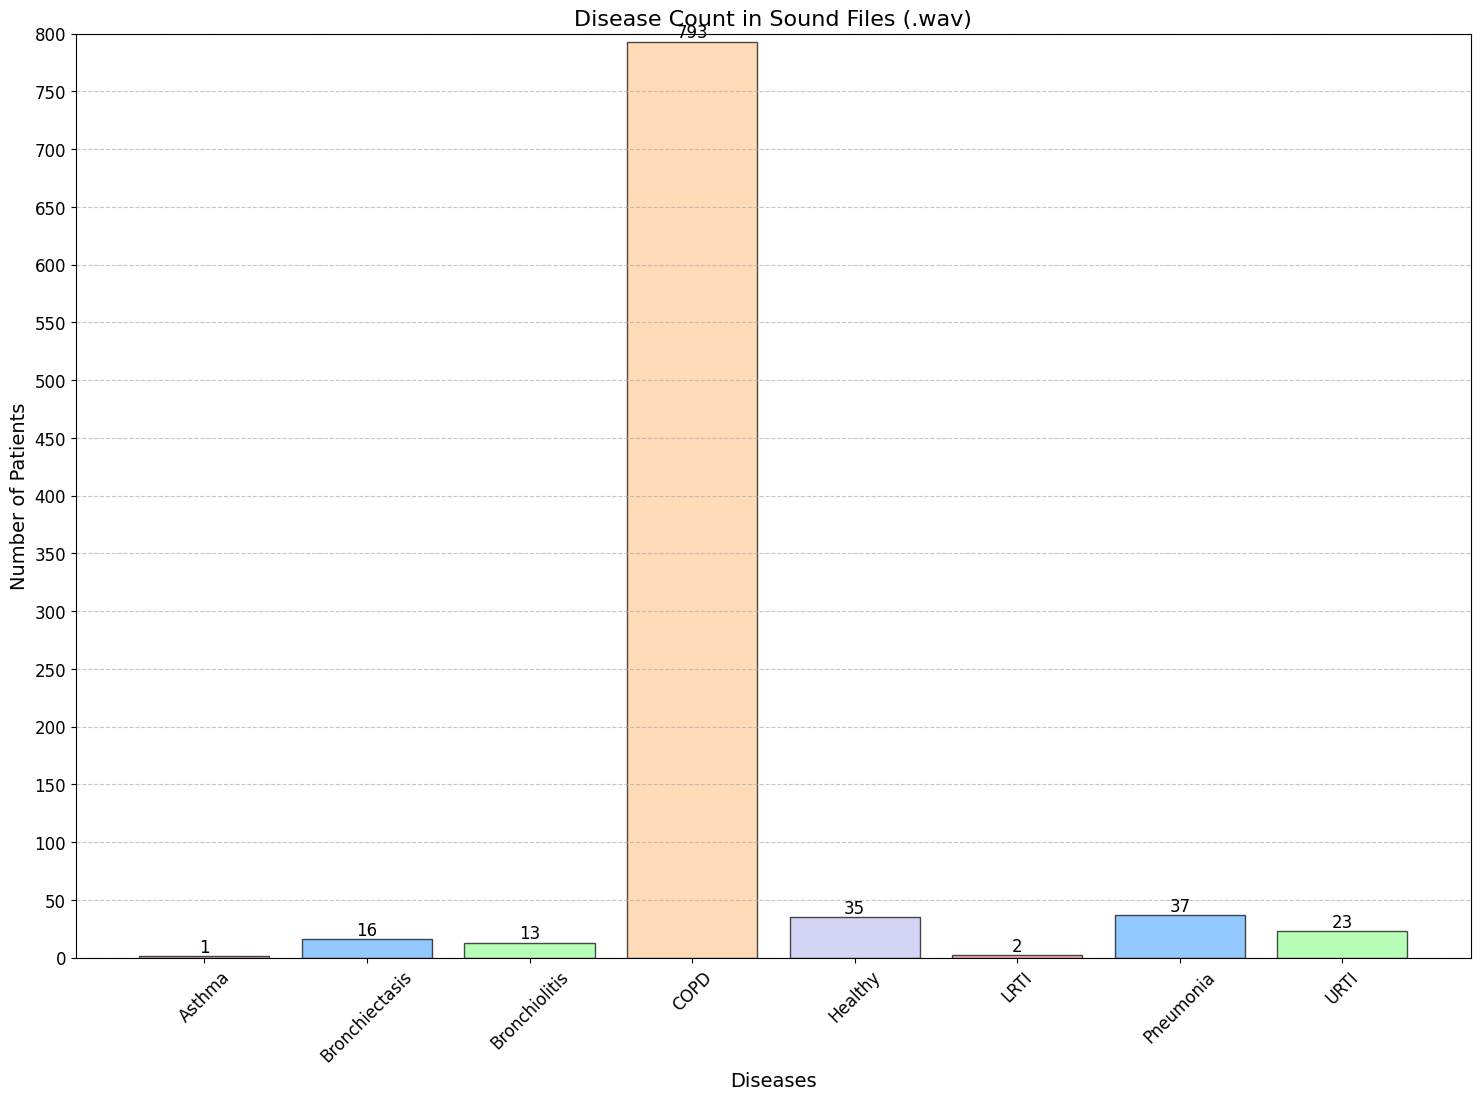

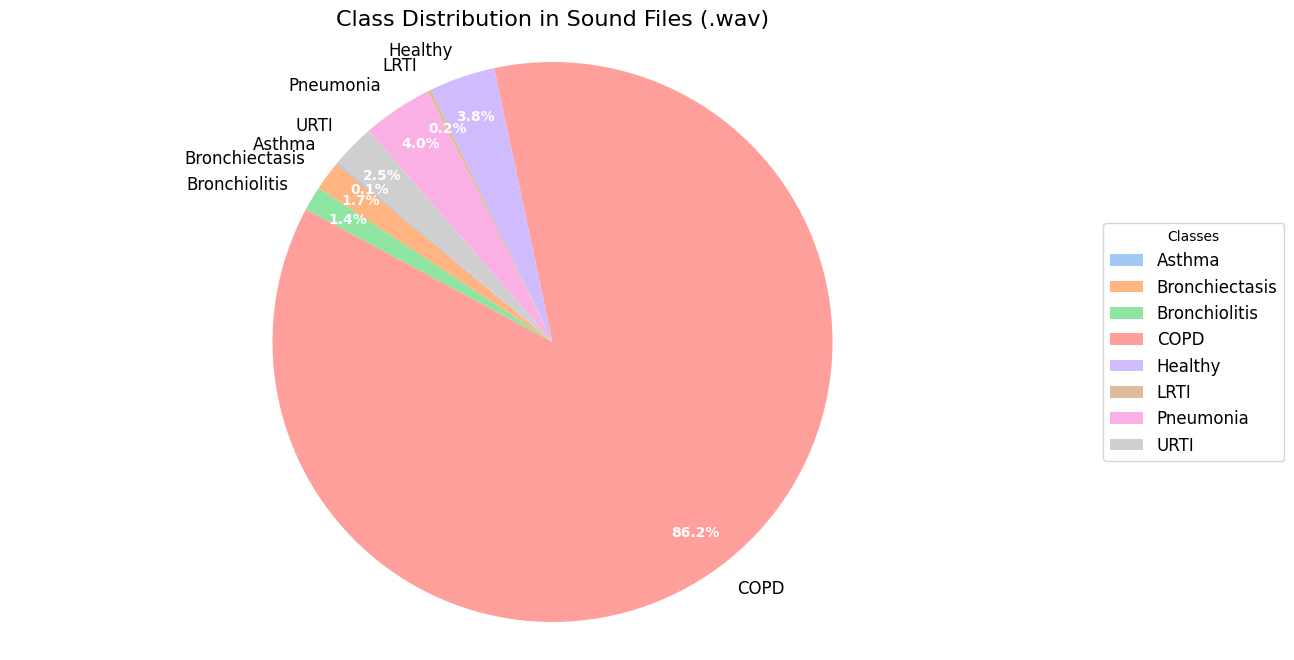

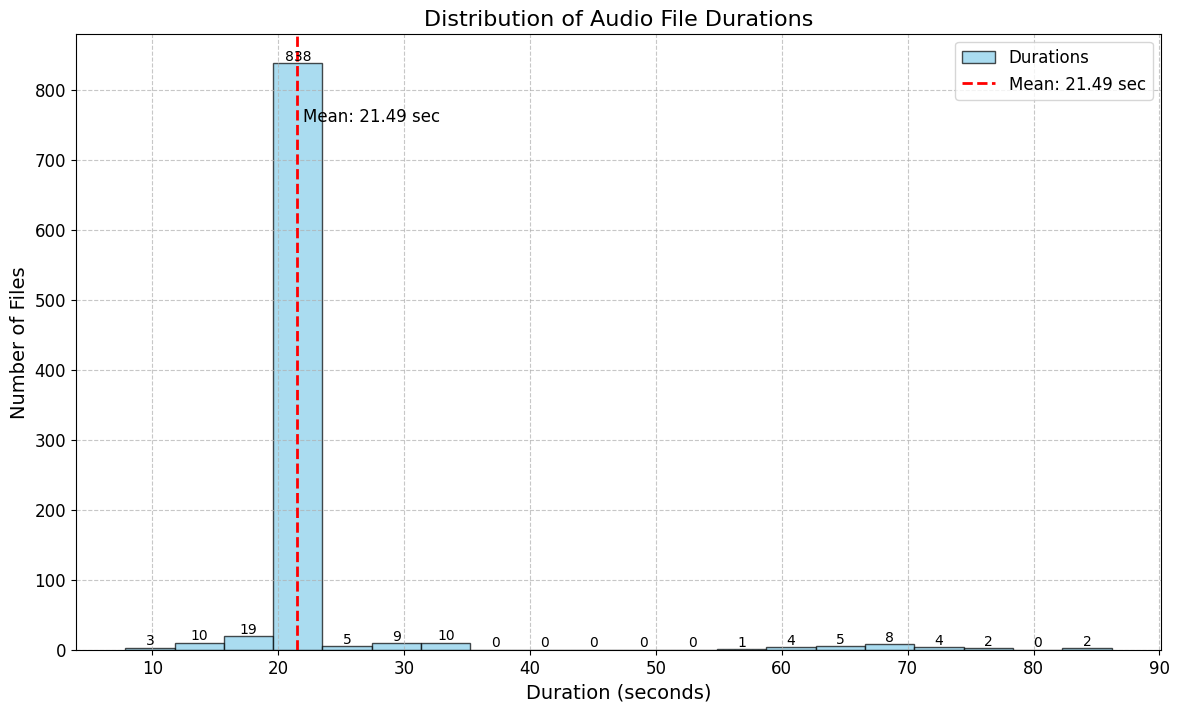

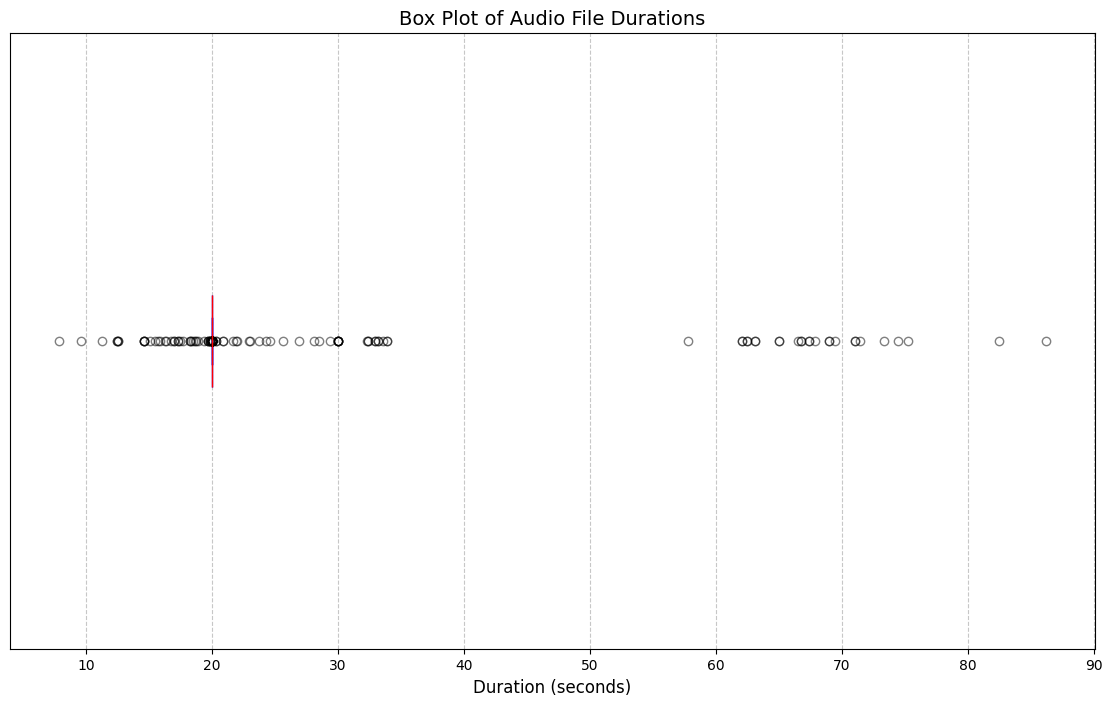


Statistical Summary of Audio File Durations (in seconds)
      mean    std    min    max
--  ------  -----  -----  -----
 0   21.49   8.31   7.86   86.2


In [6]:
try:
    ''' ==============================  CONSTANTS ============================== '''
    # List audio files in the specified directory
    filenames = [f for f in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, f)) and f.endswith('.wav')]
    if not filenames:
        raise FileNotFoundError(f"No .wav files found in directory {PATH}")

    # Extract patient IDs corresponding to each file
    p_id_in_file = np.array([int(name.split('_')[0]) for name in filenames])

    # Read patient diagnosis file
    p_diag = pd.read_csv(diagnosis_file, header=None)
    if p_diag.empty:
        raise ValueError(f"The diagnosis file {diagnosis_file} is empty or improperly formatted.")

    # Extract labels for audio files
    labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file])
    if labels.size == 0:
        raise ValueError("No matching patient IDs found in diagnosis file.")

    # Get class counts
    unique_elements, counts_elements = np.unique(labels, return_counts=True)
    class_counts = np.asarray((unique_elements, counts_elements))

    ''' ==============================  TABLE of CLASSES ============================== '''
    # Convert class counts to a list of lists for tabulate
    class_counts_list = class_counts.T.tolist()

    # Print class counts in the form of a table
    print(tabulate(class_counts_list, headers=['Classes', 'Count']))

    time.sleep(1)

    ''' ==============================  INFO (print) ============================== '''
    # Calculate and print the total number of classes
    total_classes = len(class_counts_list)
    print('\n\033[1;92mTotal Number of Classes:', total_classes, '\033[0m')

    time.sleep(1)

    # Calculate and print the total number of patients
    total_patients = np.sum(counts_elements)
    print('\033[1;92mTotal Number of Patients:', total_patients, '\033[0m')

    time.sleep(1)

    ''' ============================== BAR CHART (Disease Count in Sound Files) ============================== '''
    # Define custom colors
    colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

    # Plot class counts
    plt.figure(figsize=(18, 12))
    bars = plt.bar(unique_elements, counts_elements, align='center', alpha=0.7, color=colors, edgecolor='black')

    # Labels and title
    plt.xlabel('Diseases', fontsize=14)
    plt.ylabel('Number of Patients', fontsize=14)
    plt.title('Disease Count in Sound Files (.wav)', fontsize=16)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    # Calculate the upper limit for y-axis
    y_max = max(counts_elements)
    y_max = (y_max // 50 + 1) * 50  # Round up to the nearest multiple of 50

    # Set custom y-axis range
    plt.ylim(0, y_max)

    # Set y-axis ticks to increment by 50
    plt.yticks(np.arange(0, y_max + 1, 50))

    # Add grid lines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=12)

    # Show the plot
    plt.show()

    time.sleep(1)

    ''' ============================== PIE CHART of CLASS DISTRIBUTION ============================== '''
    # Generate pastel colors using seaborn
    colors = sn.color_palette("pastel", len(unique_elements))

    # Plot a pie chart of class distribution
    plt.figure(figsize=(14, 8))
    wedges, texts, autotexts = plt.pie(
        counts_elements, labels=unique_elements, autopct='%1.1f%%', startangle=140,
        colors=colors, shadow=False, pctdistance=0.85, labeldistance=1.1
    )

    # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.axis('equal')

    # Improve the appearance of text
    for text in texts:
        text.set_fontsize(12)
    for autotext in autotexts:
        autotext.set_fontsize(10)
        autotext.set_color('white')
        autotext.set_weight('bold')

    # Add a legend
    plt.legend(wedges, unique_elements, title="Classes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)

    # Add a title
    plt.title('Class Distribution in Sound Files (.wav)', fontsize=16)

    # Show the plot
    plt.show()

    time.sleep(1)

    # Analyze the duration of each audio file
    durations = []
    for file in filenames:
        try:
            with wave.open(os.path.join(PATH, file), 'r') as wav_file:
                frames = wav_file.getnframes()
                rate = wav_file.getframerate()
                duration = frames / float(rate)
                durations.append(duration)
        except wave.Error as e:
            print(f"Error processing {file}: {e}")

    # Plot a histogram of audio file durations
    # Calculate mean duration
    mean_duration = np.mean(durations)

    ''' ============================== HISTOGRAM of AUDIO FILE DURATION ============================== '''
    plt.figure(figsize=(14, 8))
    counts, bins, patches = plt.hist(durations, bins=20, edgecolor='black', alpha=0.7, color='skyblue', label='Durations')
    plt.axvline(mean_duration, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_duration:.2f} sec')

    # Adding labels and title
    plt.xlabel('Duration (seconds)', fontsize=14)
    plt.ylabel('Number of Files', fontsize=14)
    plt.title('Distribution of Audio File Durations', fontsize=16)

    # Adding grid lines for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Customizing tick labels
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Adding legend
    plt.legend(fontsize=12)

    # Adding annotation for the mean
    plt.text(mean_duration + 0.5, max(counts) * 0.9, f'Mean: {mean_duration:.2f} sec', fontsize=12)

    # Adding count labels above each bar
    for patch, count in zip(patches, counts):
        plt.text(patch.get_x() + patch.get_width() / 2, count, str(int(count)),
                ha='center', va='bottom', fontsize=10)

    plt.show()

    time.sleep(1)

    ''' ============================== BOX PLOT of AUDIO FILE DURATION ============================== '''
    plt.figure(figsize=(14, 8))

    # Creating a horizontal boxplot with enhanced features
    box = plt.boxplot(durations, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    whiskerprops=dict(color='blue'),
                    capprops=dict(color='blue'),
                    medianprops=dict(color='red'),
                    flierprops=dict(marker='o', color='red', alpha=0.5))

    # Adding grid lines for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adding labels and title
    plt.xlabel('Duration (seconds)', fontsize=12)
    plt.title('Box Plot of Audio File Durations', fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks([])  # Remove y-axis ticks as they are not needed for a single boxplot

    # Adding annotations for outliers
    for flier in box['fliers']:
        for outlier in flier.get_ydata():
            plt.annotate(f'{outlier:.2f}', xy=(outlier, 1), xytext=(5, 0),
                        textcoords='offset points', fontsize=10, color='red')

    plt.show()

    time.sleep(1)
    
    ''' ============================== STATISTICAL SUMMARY of AUDIO FILE DURATIONS ============================== '''
    durations_series = pd.Series(durations)
    summary_stats = durations_series.describe().round(2)

    # Select the specific statistics to display
    custom_summary = summary_stats[['mean', 'std', 'min', 'max']]

    # Convert the summary to a DataFrame for tabulate
    custom_summary_df = custom_summary.to_frame().transpose()

    # Print the statistical summary using tabulate
    print('\n\033[1;92mStatistical Summary of Audio File Durations (in seconds)\033[0m')
    print(tabulate(custom_summary_df, headers='keys', tablefmt='simple'))

except Exception as e:
    print("\033[1;91mWARNING:\033[0m An error occurred while processing class counts:")
    print("Details:", e)

## Feature Extraction

`audio_features(filename)`:
  - Loads the audio file and retrieves the sample rate.
  - Computes the Short-Time Fourier Transform (STFT) of the audio.
  - Extracts various audio features, including:
    - Mean Mel-frequency cepstral coefficients (MFCC).
    - Mean chromagram from STFT.
    - Mean mel-scaled spectrogram.
    - Mean spectral contrast.
    - Mean tonal centroid features (tonnetz).
  - Concatenates all features into a single feature vector.

In [7]:
def audio_features(filename):
    try:
        # Load the audio file and get the sample rate
        sound, sample_rate = librosa.load(filename)
        # Compute the Short-Time Fourier Transform (STFT) of the sound
        stft = np.abs(librosa.stft(sound))

        # Compute the mean Mel-frequency cepstral coefficients (MFCC) over time
        mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40), axis=1)
        # Compute the mean chromagram from STFT
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate), axis=1)
        # Compute the mean mel-scaled spectrogram
        mel = np.mean(librosa.feature.melspectrogram(y=sound, sr=sample_rate), axis=1)
        # Compute the mean spectral contrast
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate), axis=1)
        # Compute the mean tonal centroid features (tonnetz)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate), axis=1)

        # Concatenate all the features into a single feature vector
        return np.concatenate((mfccs, chroma, mel, contrast, tonnetz))
    except Exception as e:
        raise RuntimeError(f"Error extracting audio features from file {filename}: {e}")

`data_points(PATH, diagnosis_file)`:
  - Initializes lists to store labels and features.
  - Maps diagnoses to numerical labels.
  - Loads diagnosis data.
  - Iterates over each diagnosis entry:
    - Appends the numerical label for the diagnosis to the labels list.
    - Extracts audio features and appends them to the features list.
  - Prints a completion message indicating the number of files processed.
  - Returns the labels and features as numpy arrays.

In [8]:
def data_points(PATH, diagnosis_file):
    labels = []  # Initialize an empty list to store the labels
    features = []  # Initialize an empty list to store the features

    # Mapping of diagnosis to numerical labels
    diagnosis_mapping = {
        "COPD": 0, "Healthy": 1, "URTI": 2, "Bronchiectasis": 3,
        "Pneumonia": 4, "Bronchiolitis": 5, "Asthma": 6, "LRTI": 7
    }

    try:
        # Load diagnosis data from the given path and file
        diagnoses = load_diagnosis_data(PATH, diagnosis_file)
    except (ValueError, FileNotFoundError, RuntimeError) as e:
        # Print error message if there is an issue with loading the diagnosis data
        print(f"Error loading diagnosis data: {e}")
        return np.array([]), np.array([])  # Return empty arrays if an error occurs

    # Iterate over each diagnosis entry
    for diagnosis in tqdm(diagnoses, desc="Extracting Features", unit="file"):
        try:
            # Append the numerical label for the diagnosis to the labels list
            labels.append(diagnosis_mapping[diagnosis.diagnosis])
            # Extract and append the audio features to the features list
            features.append(audio_features(diagnosis.audio_file_path))
        except Exception as e:
            # Print a warning message if there is an issue with feature extraction
            tqdm.write(f"\033[1;91mWARNING:\033[0m An issue was encountered while extracting features from file: {diagnosis.audio_file_path}. Error: {e}")
    
    # Print completion message indicating the number of files processed
    print(f'\n\033[1;92mFinished feature extraction from {len(features)} files\033[0m')
    # Return the labels and features as numpy arrays
    return np.array(labels), np.array(features)

## Preprocessing

`preprocessing(labels, images)`:
  - Removes entries with labels for Asthma (6) and LRTI (7).
  - Splits data into training and testing sets.
  - One-hot encodes the labels.
  - Reshapes the data for model input.
  - Returns the preprocessed training and testing sets.

Additional steps:

- `Start timer`: Measures the preprocessing time.
- `Load data points`: Calls the `data_points` function to retrieve labels and features.
- `Preprocess data`: Calls the `preprocessing` function to prepare the data.
- `Calculate and print elapsed time`: Displays the time taken for preprocessing in minutes and seconds.
<br><br>
<p style="color:#ff3232; font-size:1.2em; font-weight:bold;">⚠️ Warning: Estimated Time of Completion (ETC): 22-25 minutes on a MacBook Air M2</p>

In [9]:
def preprocessing(labels, images):
    # Remove Asthma (label 6) and LRTI (label 7)
    indices_to_remove = np.where((labels == 6) | (labels == 7))[0]
    images = np.delete(images, indices_to_remove, axis=0)
    labels = np.delete(labels, indices_to_remove, axis=0)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=10)

    # One-hot encode the labels
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    # Reshape data
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    y_train = y_train.reshape((y_train.shape[0], 6))
    X_test = X_test.reshape((X_test.shape[0], X_train.shape[1], 1))
    y_test = y_test.reshape((y_test.shape[0], 6))

    return X_train, X_test, y_train, y_test

# Start timer
start = timer()

# Load data points
labels, images = data_points(PATH, diagnosis_file)

# Preprocess data
X_train, X_test, y_train, y_test = preprocessing(labels, images)

end = timer()
elapsed_time = end - start

# Calculate minutes and remaining seconds
minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

# Print time taken in a user-friendly format
print(f'Time taken: {minutes}:{seconds:02d} minutes ({elapsed_time:.0f} seconds)')

Extracting Features:   0%|          | 0/920 [00:00<?, ?file/s]

Extracting Features:   0%|          | 3/920 [00:10<53:39,  3.51s/file]/Users/afl/Library/Python/3.9/lib/python/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Extracting Features:  99%|█████████▊| 908/920 [24:01<00:45,  3.83s/file] /Users/afl/Library/Python/3.9/lib/python/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Extracting Features: 100%|██████████| 920/920 [24:24<00:00,  1.59s/file]


Finished feature extraction from 918 files
Time taken: 24:24 minutes (1464 seconds)


### Selecting a Random .wav File and Displaying its Mel-Spectrogram

`select_random_wav_file(PATH)`:
  - Lists all `.wav` files in the specified directory.
  - Randomly selects one `.wav` file.
  - Returns the full path of the selected file and its name.

`display_mel_spectrogram(file_path, file_name)`:
  - Loads the audio file at the given path.
  - Splices the first 5 seconds of the audio.
  - Computes the mel-spectrogram of the spliced audio.
  - Displays the mel-spectrogram with a color bar and appropriate labels.

Additional steps:

- `Select a random .wav file`: Calls the `select_random_wav_file` function to choose a file from the specified directory.
- `Display mel-spectrogram`: Calls the `display_mel_spectrogram` function to visualize the spectrogram of the selected audio file.
- `Load necessary libraries`: Imports `os`, `numpy`, `librosa`, and `matplotlib` libraries required for file handling, random selection, audio processing, and plotting.

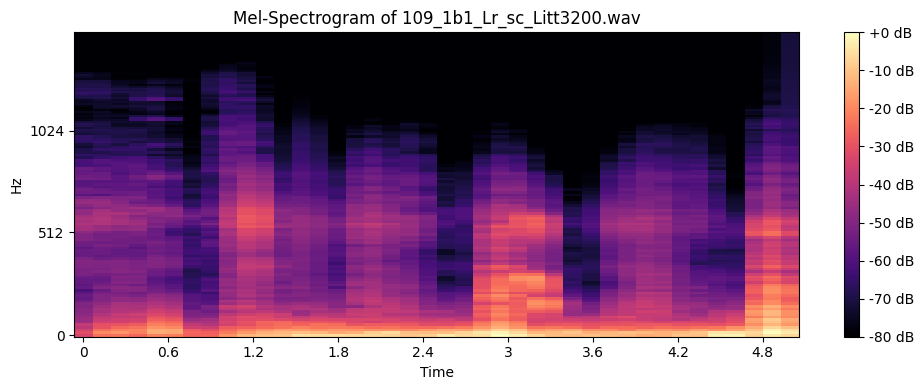

In [33]:
# Function to randomly select a .wav file from a directory
def select_random_wav_file(PATH):
    files = [f for f in os.listdir(PATH) if f.endswith('.wav')]
    random_index = np.random.randint(0, len(files))
    selected_file = files[random_index]
    return os.path.join(PATH, selected_file), selected_file

# Function to display mel-spectrogram of the spliced audio file
def display_mel_spectrogram(file_path, file_name):
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)  # Set sr=None to load the native sampling rate

    # Splice audio (example: first 5 seconds)
    duration = 5  # seconds
    y_spliced = y[:sr * duration]

    # Compute mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y_spliced, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Display mel-spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-Spectrogram of {file_name}')
    plt.tight_layout()
    plt.show()


# Select a random .wav file
random_wav_file, selected_file_name = select_random_wav_file(PATH)

# Display mel-spectrogram of the spliced audio file
display_mel_spectrogram(random_wav_file, selected_file_name)


## Building the Models
### Convolutional Neural Network (CNN)

The following functions are defined to build and train a CNN model:

- `build_model(input_shape, num_classes)`:
  - Creates a CNN model with the following layers:
    - Convolutional layers with ReLU activation.
    - MaxPooling layer.
    - Dropout layer.
    - Flatten layer.
    - Dense layers with ReLU and softmax activation.
  - Returns the constructed model.

- `compile_and_train_model(model, X_train, y_train, X_test, y_test, epochs=70, batch_size=200)`:
  - Compiles the model with categorical cross-entropy loss and Adam optimizer.
  - Trains the model on the training data with validation on the test data.
  - Prints a completion message.
  - Returns the training history.

Additional steps:

- `Define input shape and number of classes`.
- `Build the model`: Calls `build_model` with the defined input shape and number of classes.
- `Compile and train the model`: Calls `compile_and_train_model` with the model and data.


In [24]:
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape),
        Conv1D(128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(256, kernel_size=5, activation='relu'),
        Dropout(0.3),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

def compile_and_train_model(model, X_train, y_train, X_test, y_test, epochs=74, batch_size=92):
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1)
    print("\033[92mCNN Model completed!\033[0m")
    return history

# Define input shape and number of classes
input_shape = (193, 1)
num_classes = 6

# Build the model
model = build_model(input_shape, num_classes)

# Compile and train the model
history = compile_and_train_model(model, X_train, y_train, X_test, y_test)

Epoch 1/74
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.5741 - loss: 6.5429 - val_accuracy: 0.7268 - val_loss: 0.9668
Epoch 2/74
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - accuracy: 0.7794 - loss: 1.0623 - val_accuracy: 0.8743 - val_loss: 0.5460
Epoch 3/74
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.8758 - loss: 0.8461 - val_accuracy: 0.8743 - val_loss: 0.5010
Epoch 4/74
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.8659 - loss: 0.5990 - val_accuracy: 0.8743 - val_loss: 0.4536
Epoch 5/74
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.8562 - loss: 0.5118 - val_accuracy: 0.8634 - val_loss: 0.4805
Epoch 6/74
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 256ms/step - accuracy: 0.8718 - loss: 0.4184 - val_accuracy: 0.8743 - val_loss: 0.4476
Epoch 7/74
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step - accuracy: 0.8478 - loss: 0.4424 - val_accuracy: 0.8743 - val_loss: 0.4273
Epoch 8/74
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 332ms/step - accuracy: 0.8534 - loss: 0.4175 - val_accuracy: 0.8743 - val_loss:

### Artificial Neural Network (ANN)

In [12]:
# Define the ANN model
def build_ann_model(input_shape, num_output_classes):
    ann_model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_output_classes, activation='softmax')
    ])
    return ann_model

def compile_and_train_ann_model(ann_model, training_data, training_labels, validation_data, validation_labels, num_epochs=70, batch_size_value=5):
    ann_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    training_history = ann_model.fit(training_data, training_labels, validation_data=(validation_data, validation_labels), epochs=num_epochs, batch_size=batch_size_value, verbose=1)
    print("\033[92mANN Model training completed!\033[0m")
    return training_history

# Define input shape and number of classes
input_shape_ann = (193,)
num_output_classes = 6

# Build the ANN model
ann_model = build_ann_model(input_shape_ann, num_output_classes)

# Compile and train the ANN model
training_history = compile_and_train_ann_model(ann_model, X_train, y_train, X_test, y_test)

Epoch 1/70


/Users/afl/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7407 - loss: 13.6673 - val_accuracy: 0.8743 - val_loss: 1.7788
Epoch 2/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7989 - loss: 2.7289 - val_accuracy: 0.8743 - val_loss: 0.5799
Epoch 3/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7883 - loss: 1.7950 - val_accuracy: 0.8743 - val_loss: 0.5092
Epoch 4/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7666 - loss: 1.0716 - val_accuracy: 0.8525 - val_loss: 0.7115
Epoch 5/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8282 - loss: 0.6928 - val_accuracy: 0.8743 - val_loss: 0.6860
Epoch 6/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7942 - loss: 0.8487 - val_accuracy: 0.8743 - val_loss: 0.5248
Epoch 7/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8268 - loss: 0.6099 - val_accuracy: 0.8743 - val_loss: 0.4771
Epoch 8/70
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8737 - loss: 0.5427 - val_accuracy: 0.8689 - val

## Evaluation - CNN
### Plotting Accuracy & Loss
The model is evaluated on the test set, and accuracy and loss are printed in green. Learning curves for accuracy and loss are plotted to visualize model performance over epochs. The training and validation accuracy and loss values are displayed with markers, grid lines, titles, and labels for clarity.

Accuracy: 90%
Loss: 0.5765



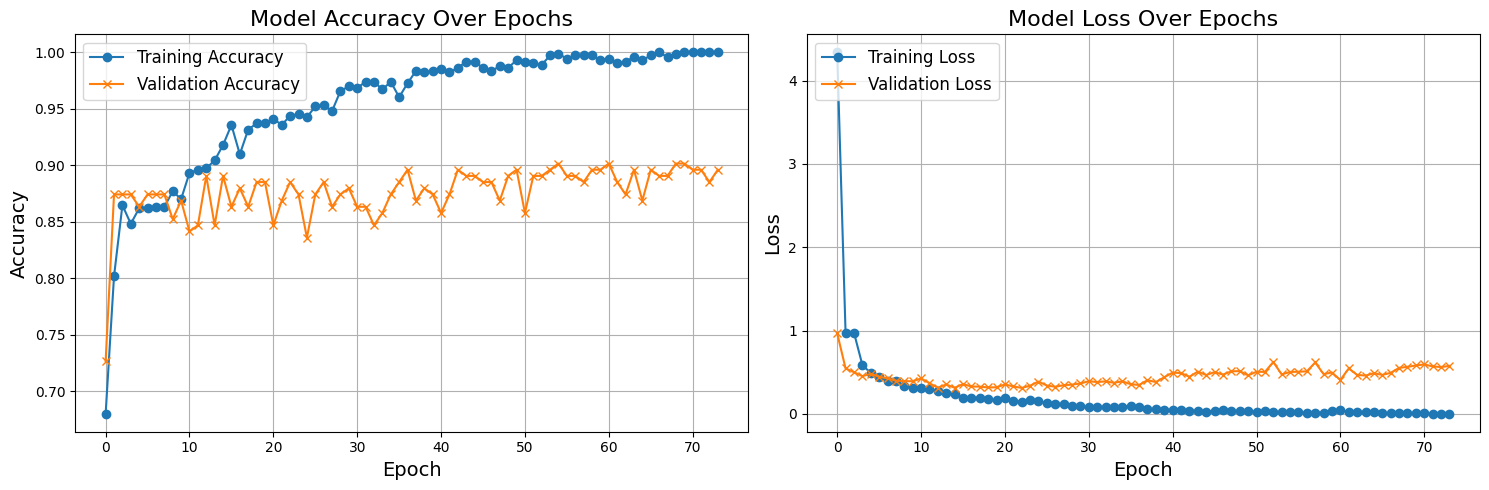

In [25]:
# Evaluate the model
score = model.evaluate(X_test, y_test, batch_size=60, verbose=0)

# Print accuracy and loss in green
accuracy = score[1]
loss = score[0]

print(f'\033[1;92mAccuracy: {accuracy:.0%}\033[0m')

time.sleep(1)

print(f"\033[1;92mLoss: {loss:.4f}\033[0m\n")

time.sleep(1)

# Plot learning curves for accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
axes[0].set_title('Model Accuracy Over Epochs', fontsize=16)
axes[0].set_ylabel('Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=14)
axes[0].legend(loc='upper left', fontsize=12)
axes[0].grid(True)

# Plot training & validation loss values
axes[1].plot(history.history['loss'], label='Training Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='x')
axes[1].set_title('Model Loss Over Epochs', fontsize=16)
axes[1].set_ylabel('Loss', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].legend(loc='upper left', fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Plotting Confusion Matrix
The confusion matrix and classification report are generated to evaluate model predictions against true labels. The confusion matrix is then displayed with percentage annotations using a heatmap.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
                precision    recall  f1-score   support

          COPD       0.97      0.97      0.97       160
       Healthy       0.50      0.14      0.22         7
          URTI       0.00      0.00      0.00         2
Bronchiectasis       0.60      0.60      0.60         5
     Pneumoina       0.60      0.75      0.67         4
 Bronchiolitis       0.33      0.20      0.25         5

      accuracy                           0.90       183
     macro avg       0.50      0.44      0.45       183
  weighted avg       0.90      0.90      0.90       183



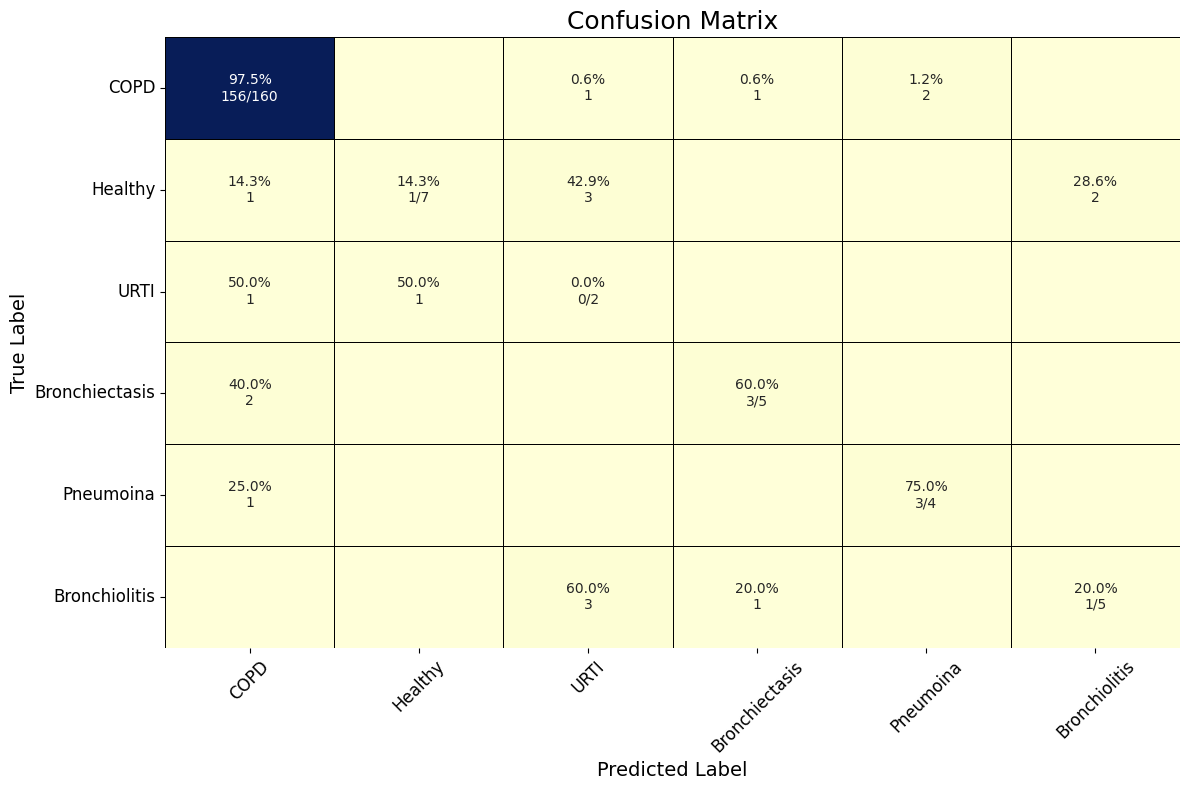

In [26]:
# Define matrix index
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis"]

# Make predictions
preds = model.predict(X_test)
class_preds = np.argmax(preds, axis=1)  # Predicted classes
y_test_class = np.argmax(y_test, axis=1)  # True classes

# Compute confusion matrix
cm = confusion_matrix(y_test_class, class_preds)
print(classification_report(y_test_class, class_preds, target_names=matrix_index))

# Calculate percentage values for the confusion matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100

# Create annotations for the confusion matrix
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            annot[i, j] = f'{p:.1f}%\n{c}/{cm_sum[i][0]}'
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = f'{p:.1f}%\n{c}'

# Display the confusion matrix
df_cm = pd.DataFrame(cm, index=matrix_index, columns=matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(figsize=(12, 8))
heatmap = sn.heatmap(df_cm, annot=annot, fmt='', cmap='YlGnBu', cbar=False, linewidths=.5, linecolor='black')
heatmap.set_title('Confusion Matrix', fontsize=18)
heatmap.set_xlabel('Predicted Label', fontsize=14)
heatmap.set_ylabel('True Label', fontsize=14)
plt.yticks(rotation=0, fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

### Plotting ROC & AUC
ROC curves are computed and plotted for each class to evaluate the model's performance. The curves and their respective AUC values are displayed in a plot with distinct colors for each class.

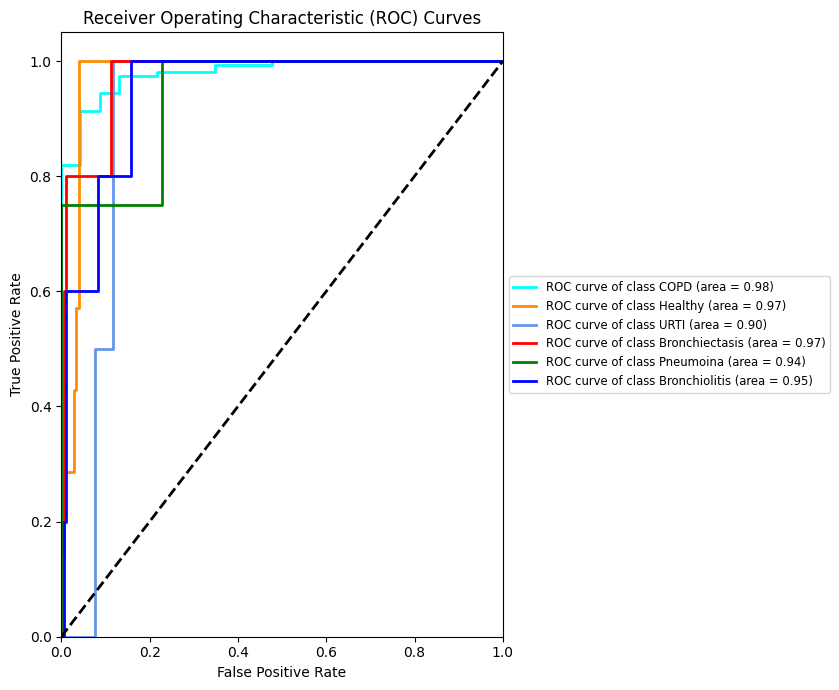

In [27]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {matrix_index[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')  # Adjust legend position
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make room on the right for the legend
plt.show()


### Plotting Precision-Recall Curves
Precision-recall curves are computed and plotted for each class to further evaluate model performance. The curves are displayed with distinct colors and labels for each class, including a legend and grid for clarity.

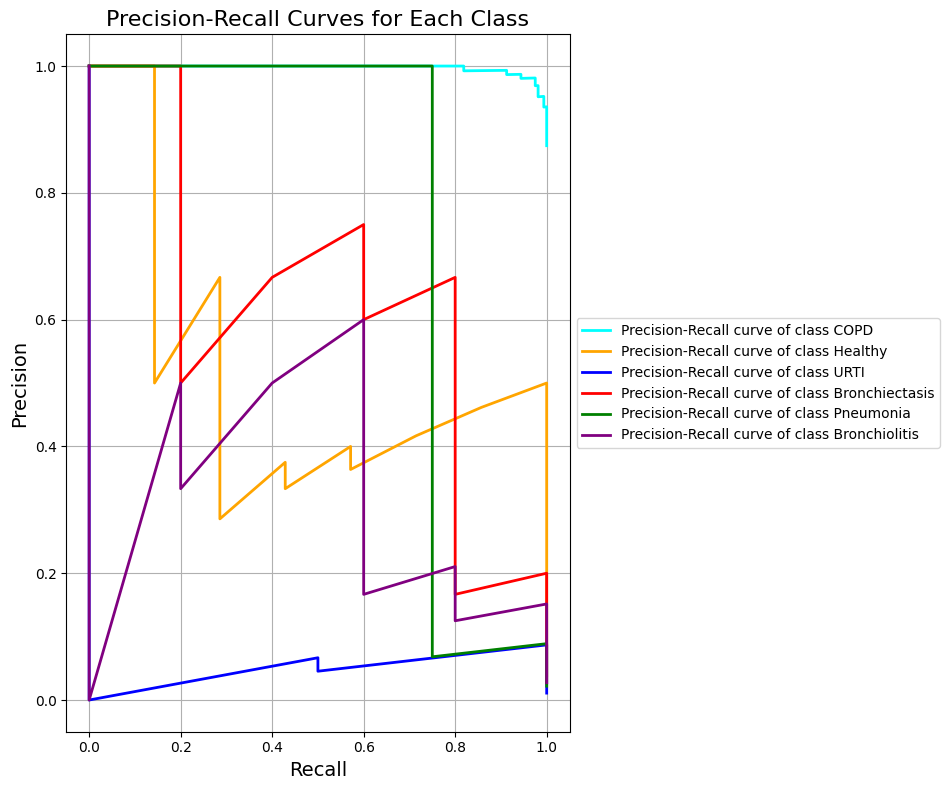

In [28]:
n_classes = 6
colors = ['cyan', 'orange', 'blue', 'red', 'green', 'purple']
matrix_index = ['COPD', 'Healthy', 'URTI', 'Bronchiectasis', 'Pneumonia', 'Bronchiolitis']

# Compute precision-recall curve for each class
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], preds[:, i])

# Plot Precision-Recall curves
plt.figure(figsize=(12, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Precision-Recall curve of class {matrix_index[i]}')

# Adding grid, titles, and labels
plt.grid(True)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curves for Each Class', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')  # Adjust legend position

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.8, 1])

plt.show()

## Evaluation - ANN

### Plotting Accuracy & Loss

Accuracy: 92%
Loss: 0.2931



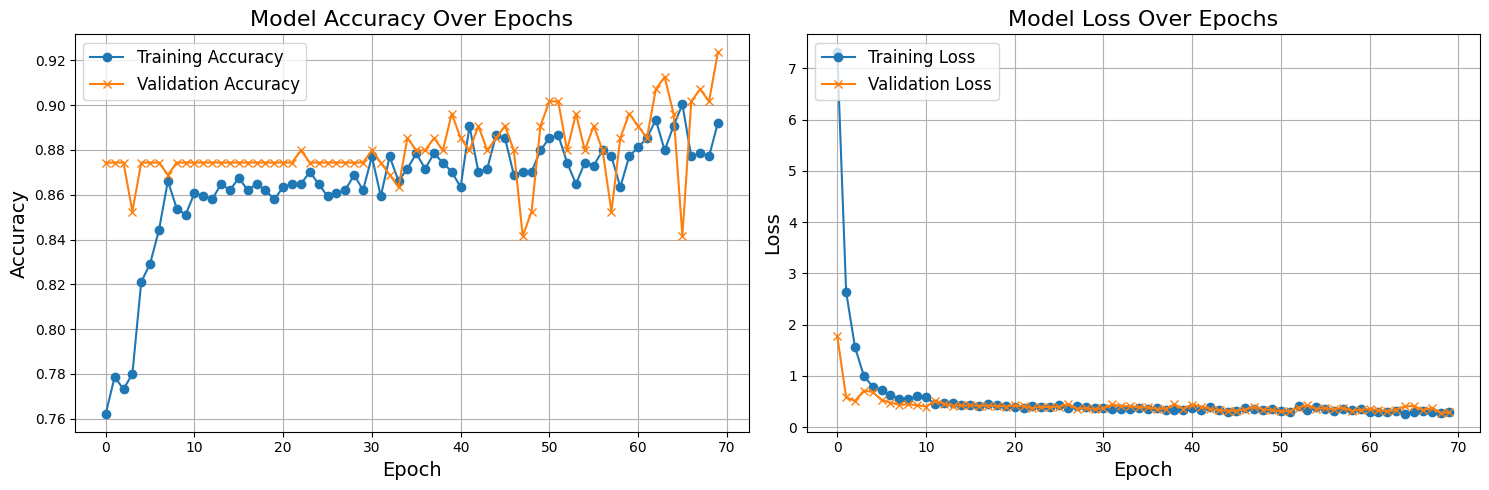

In [17]:
# Evaluate the ANN model
score = ann_model.evaluate(X_test, y_test, batch_size=200, verbose=0)

# Print accuracy and loss in green
accuracy2 = score[1]
loss2 = score[0]

print(f'\033[1;92mAccuracy: {accuracy2:.0%}\033[0m')

time.sleep(1)

print(f"\033[1;92mLoss: {loss2:.4f}\033[0m\n")

time.sleep(1)

# Plot learning curves for accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
axes[0].plot(training_history.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(training_history.history['val_accuracy'], label='Validation Accuracy', marker='x')
axes[0].set_title('Model Accuracy Over Epochs', fontsize=16)
axes[0].set_ylabel('Accuracy', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=14)
axes[0].legend(loc='upper left', fontsize=12)
axes[0].grid(True)

# Plot training & validation loss values
axes[1].plot(training_history.history['loss'], label='Training Loss', marker='o')
axes[1].plot(training_history.history['val_loss'], label='Validation Loss', marker='x')
axes[1].set_title('Model Loss Over Epochs', fontsize=16)
axes[1].set_ylabel('Loss', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].legend(loc='upper left', fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Plotting Confusion Matrix

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
                precision    recall  f1-score   support

          COPD       0.96      0.99      0.98       160
       Healthy       0.50      1.00      0.67         7
          URTI       0.00      0.00      0.00         2
Bronchiectasis       1.00      0.40      0.57         5
     Pneumonia       1.00      0.25      0.40         4
 Bronchiolitis       0.00      0.00      0.00         5

      accuracy                           0.92       183
     macro avg       0.58      0.44      0.44       183
  weighted avg       0.91      0.92      0.90       183



/Users/afl/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/afl/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/afl/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


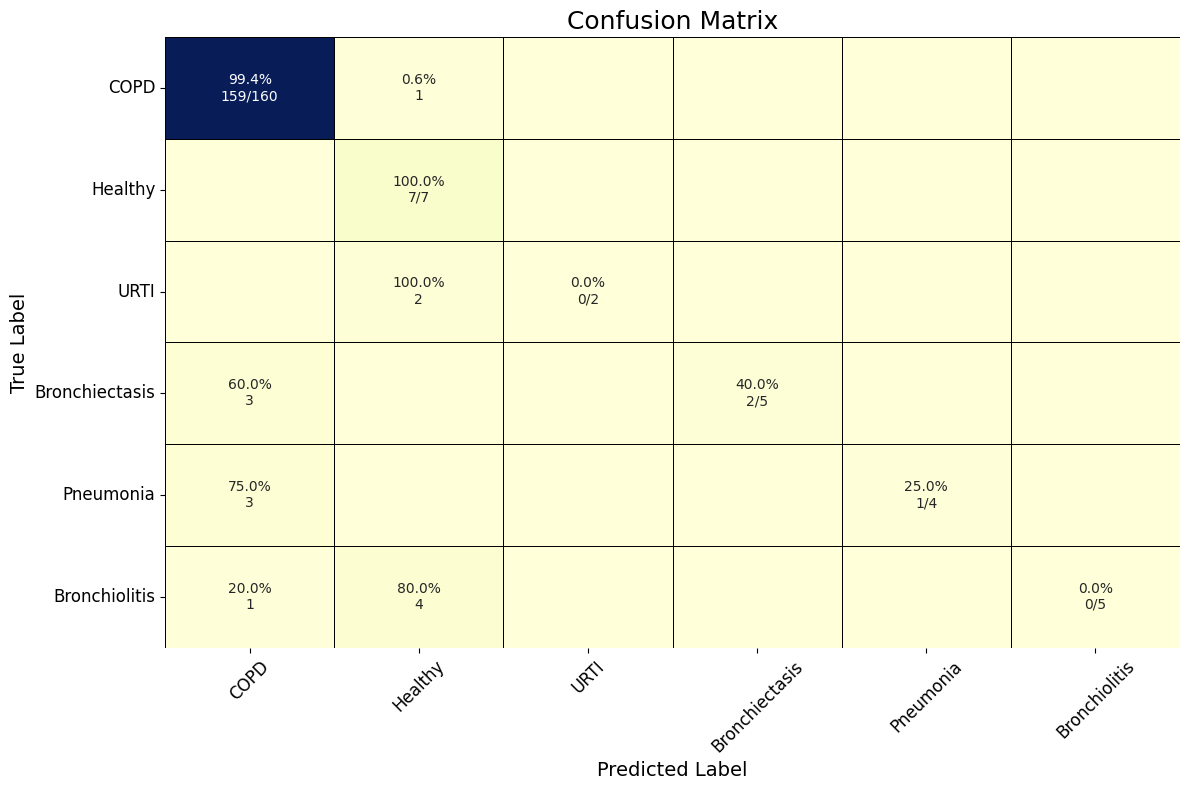

In [18]:
# Define matrix index
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumonia", "Bronchiolitis"]

# Make predictions
preds = ann_model.predict(X_test)
class_preds = np.argmax(preds, axis=1)  # Predicted classes
y_test_class = np.argmax(y_test, axis=1)  # True classes

# Compute confusion matrix
cm = confusion_matrix(y_test_class, class_preds)
print(classification_report(y_test_class, class_preds, target_names=matrix_index))

# Calculate percentage values for the confusion matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100

# Create annotations for the confusion matrix
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            annot[i, j] = f'{p:.1f}%\n{c}/{cm_sum[i][0]}'
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = f'{p:.1f}%\n{c}'

# Display the confusion matrix
df_cm = pd.DataFrame(cm, index=matrix_index, columns=matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(figsize=(12, 8))
heatmap = sn.heatmap(df_cm, annot=annot, fmt='', cmap='YlGnBu', cbar=False, linewidths=.5, linecolor='black')
heatmap.set_title('Confusion Matrix', fontsize=18)
heatmap.set_xlabel('Predicted Label', fontsize=14)
heatmap.set_ylabel('True Label', fontsize=14)
plt.yticks(rotation=0, fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()


### Plotting ROC & AUC

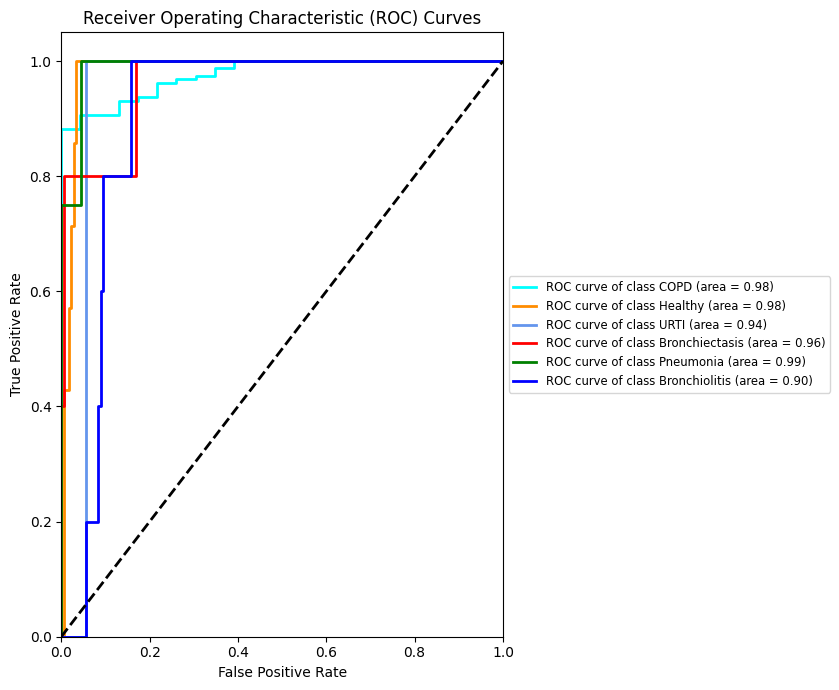

In [19]:
# Compute ROC curve and ROC area for each class
false_positive_rate = dict()
true_positive_rate = dict()
roc_auc_score = dict()
num_classes = y_test.shape[1]

for i in range(num_classes):
    false_positive_rate[i], true_positive_rate[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc_score[i] = auc(false_positive_rate[i], true_positive_rate[i])

# Plot ROC curves
plt.figure(figsize=(10, 7))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(false_positive_rate[i], true_positive_rate[i], color=color, lw=2,
             label=f'ROC curve of class {matrix_index[i]} (area = {roc_auc_score[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')  # Adjust legend position
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make room on the right for the legend
plt.show()


### Plotting Precision-Recall Curves

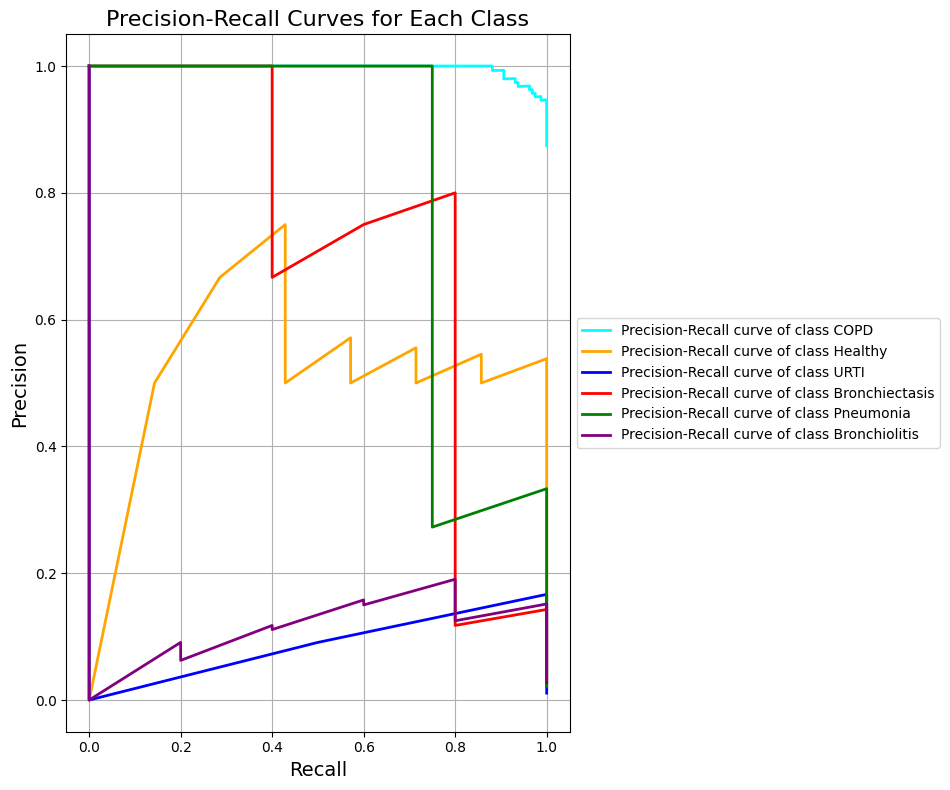

In [20]:
# Define the number of classes, class names, and colors
num_classes = 6
class_names = ['COPD', 'Healthy', 'URTI', 'Bronchiectasis', 'Pneumonia', 'Bronchiolitis']
colors = ['cyan', 'orange', 'blue', 'red', 'green', 'purple']

# Compute precision-recall curve for each class
precision_dict = {}
recall_dict = {}
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], preds[:, i])

# Plot Precision-Recall curves
plt.figure(figsize=(12, 8))
for i, color in zip(range(num_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Precision-Recall curve of class {class_names[i]}')

# Adding grid, titles, and labels
plt.grid(True)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curves for Each Class', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='medium')  # Adjust legend position

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.8, 1])

plt.show()

## Comparison of the two Models

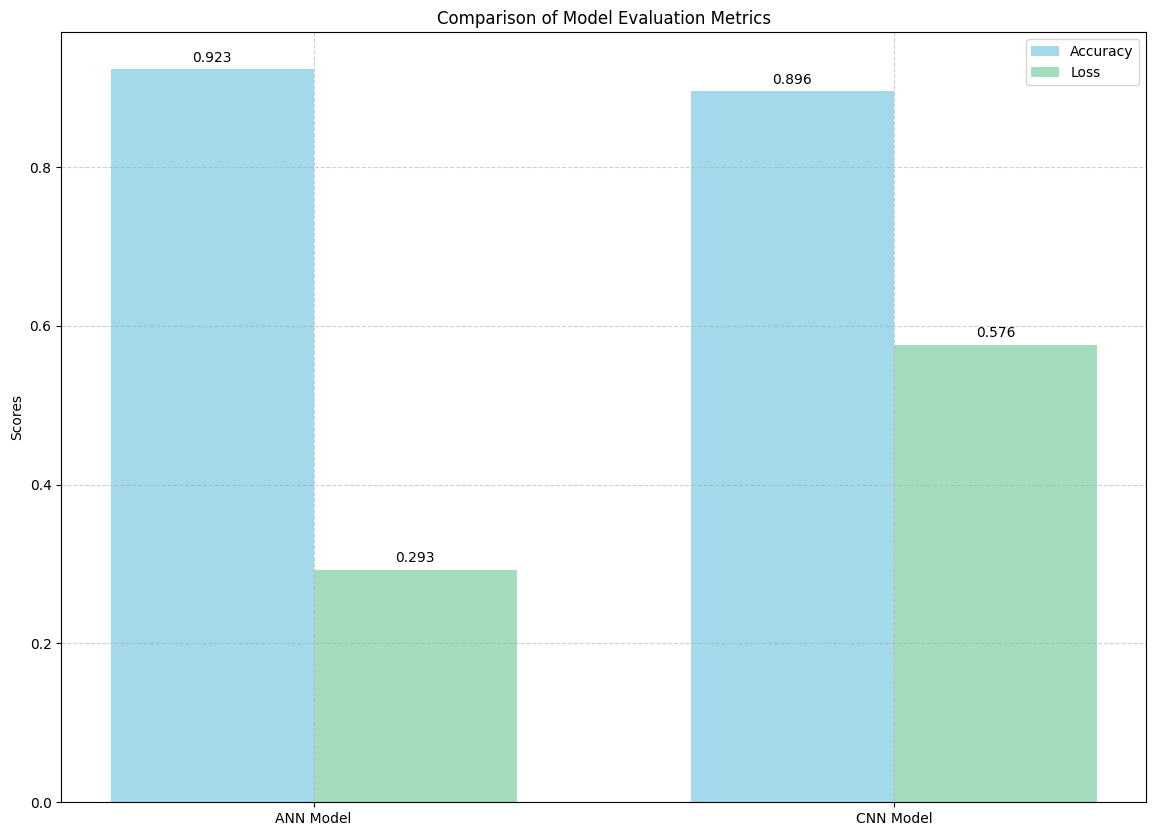

In [29]:
# Data for Model 1 (ANN Model)
ann_accuracy = accuracy2  # Using accuracy obtained from ANN model evaluation
ann_loss = loss2  # Using loss obtained from ANN model evaluation

# Data for Model 2 (CNN Model)
cnn_accuracy = accuracy  # Using accuracy obtained from model evaluation
cnn_loss = loss  # Using loss obtained from model evaluation

# Define slightly darker pastel colors
pastel_blue = '#7EC8E3'
pastel_green = '#7ECFA2'

# Plotting
labels = ['ANN Model', 'CNN Model']
accuracies = [ann_accuracy, cnn_accuracy]
losses = [ann_loss, cnn_loss]

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 10))

# Plot accuracy bars
ax.bar(x, accuracies, width, label='Accuracy', color=pastel_blue, alpha=0.7)

# Plot loss bars
ax.bar([i + width for i in x], losses, width, label='Loss', color=pastel_green, alpha=0.7)

# Attach a text label above each bar displaying its height
for i, (accuracy, loss) in enumerate(zip(accuracies, losses)):
    ax.annotate(f'{accuracy:.3f}', xy=(i, accuracy), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    ax.annotate(f'{loss:.3f}', xy=(i + width, loss), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Evaluation Metrics')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

plt.show()

## Summary and Conclusion

This notebook performed an in-depth analysis and modelling of respiratory sound data, which included the following key steps:
1. `Data Loading and Preprocessing`:
   - Audio files and diagnosis data were loaded and preprocessed.
   - Relevant audio features were extracted for model training.

2. `Data Visualization`:
   - Various plots were generated to visualize class distributions, audio file durations, and model performance.

3. `Model Building and Evaluation`:
   - A Convolutional Neural Network (CNN) was built and trained to classify respiratory diseases.
   - An Artificial Neural Network (ANN) was built and trained to classify respiratory diseases.
   - The models were evaluated using accuracy, loss, confusion matrix, ROC curves, and precision-recall curves.

4. `Results`:
   - The models showed promising results in classifying different respiratory conditions.
   - Visualizations provided insights into the model's performance and helped identify areas for improvement.